In [1]:
from Bio import SeqIO
from itertools import cycle
import warnings
import numpy as np
from dna_features_viewer import GraphicFeature, GraphicRecord, BiopythonTranslator
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
seq = SeqIO.read("<path_to>/rsv_sequence.gb",'genbank')

In [3]:
X_CODONS =  set(["AAC","AAT","ACC","ATC","ATT","CAG","CTC","CTG","GAA","GAC","GAG","GAT","GCC","GGC","GGT",
                 "GTA","GTC","GTT","TAC","TTC"])

In [5]:
def x_motif(x):
    frame_open = 0
    frame_score = 0
    codon_set = set()
    if len(x)%3 != 0:
        warnings.warn("This sequence is not divisible by 3 and will be truncated by {} bases.".format(len(x)%3))
    for i in range(0,len(x)-(len(x)%3),3):
        if x[i:i+3] in X_CODONS:
            frame_open += 3
            codon_set.update([x[i:i+3]])
        elif frame_open > 6 and len(codon_set) > 1:
            frame_score += frame_open
            frame_open = 0
            codon_set = set()
        else:
            frame_open = 0
            codon_set = set()
    else:
        #flush frame_open buffer once end of loop is reached
        #without this last X motif in sequence is never counted
        if frame_open > 6 and len(codon_set) > 1:
            frame_score += frame_open
    return frame_score

In [6]:
x_motif(str(seq.seq[2:]))

948

In [7]:
#rewrite get_scores to only do a sliding window withing the give reading frame takes as argument complete sequence
#and intervals dict
def get_scores(seq,interval_dict,window_size=150):
    scores_dict = {frame:np.zeros(len(range(frame,len(seq)-window_size,3))) for frame in interval_dict.keys()}
    for frame in interval_dict.keys():
        for interval in interval_dict[frame]:
            for i in range(interval[0],interval[1]-window_size,3):
                scores_dict[frame][i//3] = x_motif(seq[i:i+window_size])
    return scores_dict
    

In [8]:
def find_orfs(seq, min_length=120):
    """
    Find ORFs in all three forward reading frames of a nucleotide sequence.

    Parameters:
        seq (str): DNA sequence (string of A, T, G, C).
        min_length (int): Minimum ORF length in nucleotides.

    Returns:
        dict: Keys are 0, 1, 2 for the reading frames; values are lists of (start, stop) tuples.
    """
    seq = seq.upper()
    stop_codons = {'TAA', 'TAG', 'TGA'}
    start_codon = 'ATG'
    orfs = {0: [], 1: [], 2: []}

    for frame in range(3):
        i = frame
        while i < len(seq) - 2:
            codon = seq[i:i+3]
            if codon == start_codon:
                start = i
                j = i + 3
                while j < len(seq) - 2:
                    stop_codon = seq[j:j+3]
                    if stop_codon in stop_codons:
                        end = j + 3  # include stop codon
                        if end - start >= min_length:
                            orfs[frame].append((start, end))
                        break
                    j += 3
                i = j  # jump to the end of the ORF or next codon after failed ORF
            else:
                i += 3
    return orfs

In [9]:
#TODO: In order to do XME normalization, we will take the intervals generated in orf_list and perform a bedtools coverage operation
#with the -d flag to give per-base coverage. This allows normalization of the gofix scores on a per-coordinate basis for overlapping orfs

In [10]:
orf_list = find_orfs(str(seq.seq))

In [11]:
orf_list

{0: [(627, 1002), (1164, 1296), (5139, 5562), (5631, 7356), (7557, 8160)],
 1: [(2347, 3073),
  (3232, 4003),
  (4273, 4468),
  (5656, 5776),
  (8134, 8401),
  (8467, 14965)],
 2: [(98, 518),
  (1115, 2315),
  (3035, 3200),
  (4658, 5555),
  (5585, 5720),
  (10520, 10673)]}

In [12]:
'''
frame_array = np.zeros(len(seq))
for frame in orf_list:
    for intervals in orf_list[frame]:
        new_orf = np.zeros(len(seq))
        new_orf[intervals[0]:intervals[1]] += 1
        frame_array = frame_array + new_orf
'''

'\nframe_array = np.zeros(len(seq))\nfor frame in orf_list:\n    for intervals in orf_list[frame]:\n        new_orf = np.zeros(len(seq))\n        new_orf[intervals[0]:intervals[1]] += 1\n        frame_array = frame_array + new_orf\n'

In [13]:
frame_array = {}
for frame in orf_list:
    new_orf = np.zeros(len(seq))
    for intervals in orf_list[frame]:
        new_orf[intervals[0]:intervals[1]] += 1
    frame_array[frame] = new_orf


In [14]:
frame_array[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
#TODO: Get scores by iterating through intervals list instead of full sequence
window_size = 150
raw_scores = get_scores(str(seq.seq),orf_list,window_size)

In [16]:
print(len(raw_scores[0]))
print(len(raw_scores[1]))
print(len(raw_scores[2]))

5014
5014
5013


In [17]:
frame_set = set([0,1,2])
print(frame_set - set([1]))

{0, 2}


In [18]:
gofix_scores = {}
frame_set = set([0,1,2])
lf_debug = []
array_range = min([len(raw_scores[f]) for f in raw_scores.keys()])
for frame in raw_scores:
    new_score = []
    #Score is XL_f
    for i,score in enumerate(range(array_range)):
        #Need to calculate l_f
        l_f = window_size
        for other_frame in frame_set - set([frame]):
            l_f -= raw_scores[other_frame][i] * np.max(frame_array[other_frame][(i*3)+other_frame:(i*3)+window_size])
        new_score.append((100/l_f)*raw_scores[frame][i])
        lf_debug.append(l_f)
    gofix_scores[frame] = np.array(new_score)
        

In [19]:
100/min(lf_debug)

1.1111111111111112

In [20]:
gofix_scores[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
np.where(frame_array[0] !=0)

(array([ 627,  628,  629, ..., 8157, 8158, 8159], dtype=int64),)

In [22]:
seq.features = [f for f in seq.features if f.type == 'CDS']

In [23]:
feature_frames = {f.qualifiers['gene'][0]:f.location.start%3 for f in seq.features}

In [24]:
feature_frames

{'NS1': 2,
 'NS2': 0,
 'N': 2,
 'P': 1,
 'M': 1,
 'SH': 1,
 'G': 2,
 'F': 0,
 'M2': 0,
 'L': 1}

In [25]:
color_dict = {0:'#f14722',1:'#26deba',2:'#dd7cee'}

In [26]:
#graphic_record = BiopythonTranslator().translate_record("C:/Users/notor/Documents/Phil_School_2024/Phil_School_2024/Seto_lab_rotation/sars2_refseq.gb")
graphic_record = BiopythonTranslator().translate_record(seq)


In [27]:
for gf in graphic_record.features:
    gf.color = color_dict[feature_frames[gf.label]]

In [28]:
graphic_record.features[0].label

'NS1'

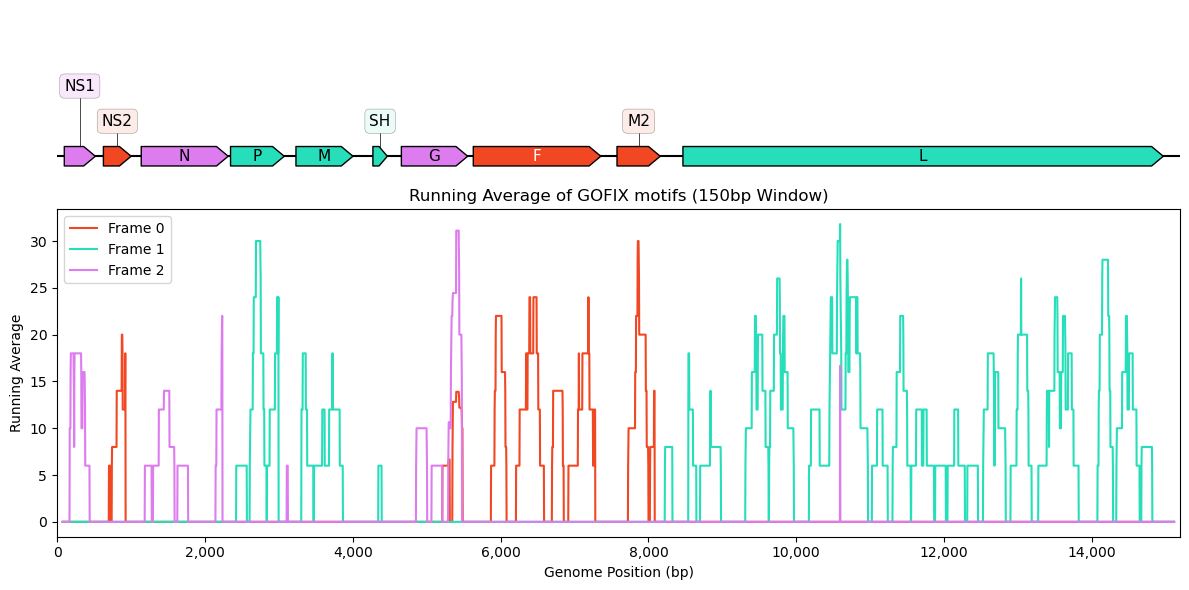

In [29]:
#whole genome
x_positions_frame_1 = [i * 3 + (window_size // 2) for i in range(len(gofix_scores[0]))]
x_positions_frame_2 = [i * 3 + (window_size // 2) for i in range(len(gofix_scores[1]))]
x_positions_frame_3 = [i * 3 + (window_size // 2) for i in range(len(gofix_scores[2]))]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6), sharex=True,
                               gridspec_kw={"height_ratios": [1, 2]})
graphic_record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=7)
ax2.plot(x_positions_frame_1, gofix_scores[0], label="Frame 0",color=color_dict[0])
ax2.plot(x_positions_frame_2, gofix_scores[1], label="Frame 1",color=color_dict[1])
ax2.plot(x_positions_frame_3, gofix_scores[2], label="Frame 2",color=color_dict[2])
ax2.set_ylabel("Running Average")
ax2.set_xlabel("Genome Position (bp)")
ax2.legend()
ax2.set_title("Running Average of GOFIX motifs (150bp Window)")

plt.tight_layout()
plt.show()

75

In [76]:
#TODO: Graph reverse strand

In [31]:
rev_seq = seq.seq.reverse_complement()

In [33]:
rev_orf_list = find_orfs(str(rev_seq))

In [34]:
rev_orf_list

{0: [(7098, 7371),
  (8322, 8481),
  (8565, 8706),
  (9270, 9432),
  (10905, 11037),
  (14460, 14700)],
 1: [(2086, 2239), (8089, 8254), (8437, 8698), (9910, 10045), (10192, 10471)],
 2: [(2447, 2642),
  (2996, 3332),
  (3776, 3896),
  (5405, 5585),
  (6074, 6197),
  (9632, 9791),
  (11375, 11906),
  (12038, 12398),
  (12659, 12875),
  (12995, 13229)]}

In [35]:
rev_raw_scores = get_scores(str(rev_seq),rev_orf_list,window_size)

In [36]:
rev_gofix_scores = {}
frame_set = set([0,1,2])
lf_debug = []
array_range = min([len(rev_raw_scores[f]) for f in rev_raw_scores.keys()])
for frame in rev_raw_scores:
    new_score = []
    #Score is XL_f
    for i,score in enumerate(range(array_range)):
        #Need to calculate l_f
        l_f = window_size
        for other_frame in frame_set - set([frame]):
            l_f -= rev_raw_scores[other_frame][i] * np.max(frame_array[other_frame][(i*3)+other_frame:(i*3)+window_size])
        new_score.append((100/l_f)*rev_raw_scores[frame][i])
        lf_debug.append(l_f)
    rev_gofix_scores[frame] = np.array(new_score)

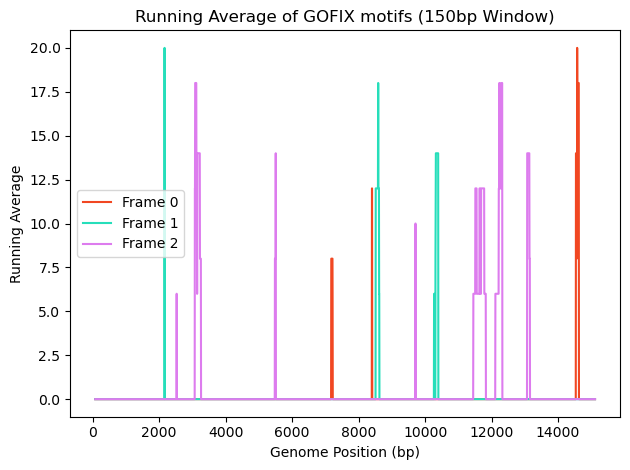

In [39]:
#whole genome
rev_x_positions_frame_1 = [i * 3 + (window_size // 2) for i in range(len(rev_gofix_scores[0]))]
rev_x_positions_frame_2 = [i * 3 + (window_size // 2) for i in range(len(rev_gofix_scores[1]))]
rev_x_positions_frame_3 = [i * 3 + (window_size // 2) for i in range(len(rev_gofix_scores[2]))]
plt.plot(rev_x_positions_frame_1, rev_gofix_scores[0], label="Frame 0",color=color_dict[0])
plt.plot(rev_x_positions_frame_2, rev_gofix_scores[1], label="Frame 1",color=color_dict[1])
plt.plot(rev_x_positions_frame_3, rev_gofix_scores[2], label="Frame 2",color=color_dict[2])
plt.ylabel("Running Average")
plt.xlabel("Genome Position (bp)")
plt.legend()
plt.title("Running Average of GOFIX motifs (150bp Window)")

plt.tight_layout()
plt.show()

In [41]:
str(seq.seq[5139: 5562].translate())

'MIFTLKCSTLYLAAYAATIQPAGLSVKEYQTKNLERKPPPSPQKNQPSRQPKKISNLKPQNQRKYLPPSPQKSQPSTPPKQTSELHCSPTIPQEIQNTQVKREPSTQPPPMAIQALHKSIQHPSTYHNLHLHPTQQTSSH*'

In [7]:
str(seq.seq[5139: 5562])

'ATGATTTTCACTTTGAAGTGTTCAACTTTGTACCTTGCAGCATATGCAGCAACAATCCAACCTGCTGGGCTATCTGTAAAAGAATACCAAACAAAAAACCTGGAAAGAAAACCACCACCAAGCCCACAAAAAAACCAACCATCAAGACAACCAAAAAAGATCTCAAACCTCAAACCACAAAACCAAAGGAAGTACCTACCACCAAGCCCACAGAAAAGCCAACCATCAACACCACCAAAACAAACATCAGAACTACACTGCTCACCAACAATACCACAGGAAATCCAGAACACACAAGTCAAAAGGGAACCCTCCACTCAACCTCCTCCGATGGCAATCCAAGCCCTTCACAAGTCTATACAACATCCGAGTACCTATCACAACCTCCATCTCCATCCAACACAACAAACCAGTAGTCATTAA'

In [ ]:
#5458: QPP

In [40]:
seq.id

'NC_001803.1'